<a href="https://colab.research.google.com/github/aapoorv-tf/abs-summarizer-using-seq2seq/blob/main/seq2seq_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')
 
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.41.250.98:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.41.250.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.41.250.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
raw = pd.read_csv("/content/gdrive/MyDrive/IR Project/Dataset/SmallDataset/news_summary_more.csv", encoding='iso-8859-1')
summary = pd.read_csv("/content/gdrive/MyDrive/IR Project/Dataset/SmallDataset/news_summary.csv", encoding='iso-8859-1')

In [5]:
pre1 =  raw.iloc[:,0:2].copy()
pre2 = summary.iloc[:,0:6].copy()

pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [6]:
data = pd.DataFrame()
data['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
data['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [7]:
import re

def text_strip(column):
    for row in column:
               
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   
        row=re.sub("(--+)", ' ', str(row)).lower()   
        row=re.sub("(~~+)", ' ', str(row)).lower()   
        row=re.sub("(\+\++)", ' ', str(row)).lower()   
        row=re.sub("(\.\.+)", ' ', str(row)).lower()  
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower()
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower()
        row=re.sub("(\-\s+)", ' ', str(row)).lower() 
        row=re.sub("(\:\s+)", ' ', str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower()
        
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
                
        row = re.sub("(\s+)",' ',str(row)).lower()         
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
                
        yield row

In [9]:
brief_cleaning1 = text_strip(data['text'])
brief_cleaning2 = text_strip(data['summary'])

In [10]:
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

In [11]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

In [12]:
data['cleaned_text'] = pd.Series(text)
data['cleaned_summary'] = pd.Series(summary)

In [77]:
data.head()

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,_START_ upgrad learner switches to career in ml al with 90% salary hike _END_
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,_START_ delhi techie wins free food from swiggy for one year on cred _END_
2,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,New Zealand end Rohit Sharma-led India's 12-match winning streak,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,_START_ new zealand end rohit sharma-led india 12-match winning streak _END_
3,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",Aegon life iTerm insurance plan helps customers save tax,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,_START_ aegon life iterm insurance plan helps customers save tax _END_
4,"Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I...","Have known Hirani for yrs, what if MeToo claims are not true: Sonam",speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said ve known hirani for many years what if it not true the #metoo movement will get derailed in the #metoo mo...,_START_ have known hirani for yrs what if metoo claims are not true sonam _END_


In [13]:
wc = pd.DataFrame()
wc['article_count'] = data['cleaned_text'].apply(lambda x: len(str(x).split()))
for i in range(90,100):
  var = wc['article_count'].values
  var = np.sort(var,axis=None)
  print('At {} percentile, word count is {}'.format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile - ",var[-1])

At 90 percentile, word count is 60
At 91 percentile, word count is 60
At 92 percentile, word count is 60
At 93 percentile, word count is 61
At 94 percentile, word count is 61
At 95 percentile, word count is 62
At 96 percentile, word count is 154
At 97 percentile, word count is 263
At 98 percentile, word count is 354
At 99 percentile, word count is 478
100 percentile -  11994


In [14]:
wc = pd.DataFrame()
wc['summary_count'] = data['cleaned_summary'].apply(lambda x: len(str(x).split()))
for i in range(90,100):
  var = wc['summary_count'].values
  var = np.sort(var,axis=None)
  print('At {} percentile, word count is {}'.format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile - ",var[-1])

At 90 percentile, word count is 13
At 91 percentile, word count is 13
At 92 percentile, word count is 13
At 93 percentile, word count is 13
At 94 percentile, word count is 14
At 95 percentile, word count is 14
At 96 percentile, word count is 14
At 97 percentile, word count is 14
At 98 percentile, word count is 14
At 99 percentile, word count is 15
100 percentile -  18


In [15]:
max_text_len=110
max_summary_len=15

In [16]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [17]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.2,random_state=0,shuffle=True)

In [19]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.08391960464777
Total Coverage of rare words: 1.4414717324467146


In [21]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 31638


In [22]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [23]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.99474467632675
Total Coverage of rare words: 3.870369716116484


In [24]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 10866


In [25]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [26]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [27]:
from keras import backend as K 

K.clear_session()

latent_dim = 300
embedding_dim=200


def seq2seq():

  global encoder_inputs
  global enc_emb
  global encoder_outputs
  global state_h
  global state_c
  global decoder_inputs
  global dec_emb_layer
  global decoder_lstm
  global decoder_dense

  encoder_inputs = Input(shape=(max_text_len,))

  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  decoder_inputs = Input(shape=(None,))

  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  return model



In [28]:
with tpu_strategy.scope():
  model=seq2seq()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 200)     6327600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 110, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
from tensorflow.keras import optimizers
nadam = optimizers.Nadam(lr=0.0001,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-8, 
                         schedule_decay=0.004)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=nadam)

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [32]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
615/615 [==============================] - 132s 170ms/step - loss: 5.9723 - val_loss: 5.2990
Epoch 2/50
615/615 [==============================] - 83s 135ms/step - loss: 5.1930 - val_loss: 5.0300
Epoch 3/50
615/615 [==============================] - 83s 134ms/step - loss: 5.0352 - val_loss: 4.9399
Epoch 4/50
615/615 [==============================] - 83s 135ms/step - loss: 4.9603 - val_loss: 4.8862
Epoch 5/50
615/615 [==============================] - 83s 134ms/step - loss: 4.9070 - val_loss: 4.8420
Epoch 6/50
615/615 [==============================] - 83s 136ms/step - loss: 4.8633 - val_loss: 4.8087
Epoch 7/50
615/615 [==============================] - 83s 134ms/step - loss: 4.8232 - val_loss: 4.7735
Epoch 8/50
615/615 [==============================] - 83s 134ms/step - loss: 4.7816 - val_loss: 4.7330
Epoch 9/50
615/615 [==============================] - 83s 134ms/step - loss: 4.7358 - val_loss: 4.6961
Epoch 10/50
615/615 [==============================] - 83s 135ms/step - 

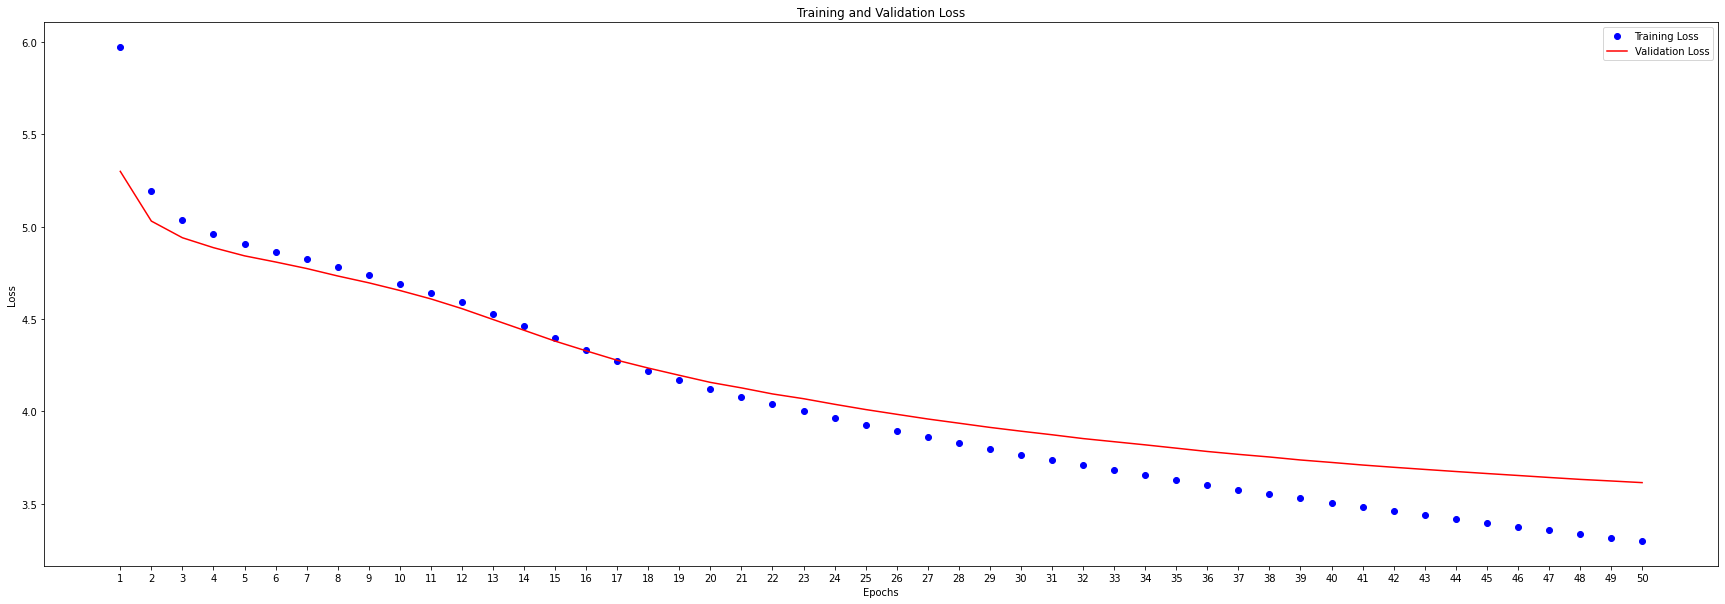

In [46]:
import matplotlib.pyplot as plt

history = model.history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 51)
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 
 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [37]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [38]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [72]:
for i in range(0,5):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis
Original summary: start pope avoids mention of rohingyas in key myanmar speech end 
Predicted summary:  start pope urges un to help rohingya muslims end

Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary: start students seen washing dishes at govt school in up end 
Predicted summary:  start up school students celebrate day with up school end

Review: apple india profit surged by 

In [40]:
!pip install rouge-score

In [76]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
Rouge1=0
RougeL=0
for i in range(len(x_val)):
  scores = scorer.score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len)))
  Rouge1 += scores['rouge1'][1]
  RougeL += scores['rougeL'][1]

Rouge1 /= len(x_val)
RougeL /= len(x_val)

print("Rouge-1 Score: ",Rouge1)
print("Rouge-L Score: ",RougeL)

Rouge-1 Score:  0.38461538461538464
Rouge-L Score:  0.35714285714285715
